# Importing the required Libaries and other Functions


In [1]:
import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName2")
sc = SparkContext(conf=conf)

In [2]:
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when
#from graphframes import *

# initialise sc
#from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql.types import *
#sc= SparkContext()
sqlContext = SQLContext(sc)


In [3]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf


import csv
import matplotlib.pyplot as plt
import gmplot
import pandas as pd
import numpy as np


In [4]:
# test that config loaded correctly
rdd = sc.textFile("/data/mr/wordcount/input/")
print(rdd.take(10))
print(sc.version)

['The Project Gutenberg EBook of The Adventures of Sherlock Holmes', 'by Sir Arthur Conan Doyle', '(#15 in our series by Sir Arthur Conan Doyle)', '', 'Copyright laws are changing all over the world. Be sure to check the', 'copyright laws for your country before downloading or redistributing', 'this or any other Project Gutenberg eBook.', '', 'This header should be the first thing seen when viewing this Project', 'Gutenberg file.  Please do not remove it.  Do not change or edit the']
2.4.3


 # 2 Loading the road safety dataset(casualty & accident) into rdd

In [5]:
#creating an rdd from the casualty dataset using the sc.textFile function
rdd_acc1 = sc.textFile("hdfs:///user/imat5322_482153/road-casualty-statistics-casualty-1979-2020.csv")

In [6]:
#to check if our file loaded correctly
rdd_acc1.take(2)

['accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile',
 '197901A11AD14,1979,01A11AD14,2,1,1,1,-1,-1,3,0,0,0,0,-1,104,-1,-1']

In [7]:
#to know the amount of observations in the dataset
rdd_acc1.count()

11449313

In [8]:
#creating an rdd from the accident dataset using the sc.textFile function
rdd_acc2 = sc.textFile("hdfs:///user/imat5322_482153/dft-road-casualty-statistics-accident-1979-2020.csv")

In [9]:
rdd_acc2.take(2)

['accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location',
 '197901A11AD14,1979,01A11AD14,NULL,NULL,NULL,NULL,1,3,2,1,18/01/1979,5,08:00,11,-1,-1,3,4,1,30,1,4,-1,-1,-1,-1,1,8,1,-1,0,-1,-1,-1,-1']

In [10]:
rdd_acc2.count()

8602825

In [11]:
#splitting our data into single lines using map and lambda function 
#choosing our desired column variables from the accident dataset using map and lambda function
rdd_acc3 = rdd_acc2.map(lambda x: x.split(',')).map(lambda x: (str(x[0]), str(x[1]), \
str(x[5]), str(x[6]), str(x[8]), str(x[9]), str(x[10]), str(x[11]), str(x[12]), str(x[13]),\
str(x[14]), str(x[19]), str(x[20]), str(x[27]), str(x[28]), str(x[29]), str(x[30]), str(x[32]), str(x[33]))) 

In [12]:
#call an action to ensure new rdd was created
rdd_acc3.first()

('accident_index',
 'accident_year',
 'longitude',
 'latitude',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'road_type',
 'speed_limit',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident')

In [13]:
#splits the rdd into lines and creates a new rdd that contains the variable columns we need for our analysis and visualization
rdd_acc4 = rdd_acc1.map(lambda x: x.split(','))\
.map(lambda x: (str(x[0]), str(x[5]), str(x[6]), str(x[7]), str(x[9]), str(x[15])))

In [14]:
#call an action to ensure new rdd was created
rdd_acc4.take(2)

[('accident_index',
  'casualty_class',
  'sex_of_casualty',
  'age_of_casualty',
  'casualty_severity',
  'casualty_type'),
 ('197901A11AD14', '1', '1', '-1', '3', '104')]

# PREPARING RDD FOR CONVERSION TO DATAFRAME 

In [15]:
#Removal of header from the created rdds to be replaced later by a claerly defined schema
#we start by creating an rdd for the headers
header1 = rdd_acc3.first()
header2 = rdd_acc4.first()

In [16]:
#checking if our header was created
header1

('accident_index',
 'accident_year',
 'longitude',
 'latitude',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'road_type',
 'speed_limit',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident')

In [17]:
#checking if our header was created
header2

('accident_index',
 'casualty_class',
 'sex_of_casualty',
 'age_of_casualty',
 'casualty_severity',
 'casualty_type')

In [18]:
#Remove the headers by filtering header1 and header2 from rdd_acc3 and rdd_acc4
rdd_acc5 = rdd_acc3.filter(lambda x: x!=header1)
rdd_acc6 = rdd_acc4.filter(lambda x: x!=header2)

In [19]:
#checking if our rdds were created
#rdds without headers created
rdd_acc5.first()

('197901A11AD14',
 '1979',
 'NULL',
 'NULL',
 '3',
 '2',
 '1',
 '18/01/1979',
 '5',
 '08:00',
 '11',
 '1',
 '30',
 '1',
 '8',
 '1',
 '-1',
 '-1',
 '-1')

In [20]:
#rdd without header created
rdd_acc6.first()

('197901A11AD14', '1', '1', '-1', '3', '104')

In [21]:
#creating a defined schema for rdd_acc5 for conversion to dataframe
Acc_Schema = StructType([\
StructField('Accident_Index', StringType(), True), \
StructField('Accident_Year', StringType(), True), \
StructField('Longitude', StringType(), True), \
StructField('Latitude', StringType(), True), \
StructField('Accident_Severity', StringType(), True), \
StructField('Number_of_Vehicles', StringType(), True), \
StructField('Number_of_Casualties', StringType(), True), \
StructField('Date', StringType(), True), \
StructField('Day_of_Week', StringType(), True), \
StructField('Time', StringType(), True), \
StructField('Local_Authority_District', StringType(), True), \
StructField('Road_Type', StringType(), True), \
StructField('Speed_Limit', StringType(), True), \
StructField('Light_Conditions', StringType(), True), \
StructField('Weather_Conditions', StringType(), True), \
StructField('Road_Surface_Conditions', StringType(), True), \
StructField('Special_Conditions', StringType(), True), \
StructField('Area_Type', StringType(), True), \
StructField('Police_Officer_attend_accident', StringType(), True)])


In [22]:
#creating a defined schema for rdd_acc6 for conversion to a dataframe
Cas_Schema= StructType([\
StructField('Accident_Index1', StringType(), True), \
StructField('Casualty_Class', StringType(), True), \
StructField('Sex', StringType(), True), \
StructField('Age', StringType(), True), \
StructField('Casualty_Severity', StringType(), True),\
StructField('Casualty_Type', StringType(), True)])

# CONVERTING THE ACCIDENT AND CASUALTY RDD TO DATAFRAMES

In [23]:
#creating a dataframe(accidents) from rdd_acc5 and our defined schema
accidents = sqlContext.createDataFrame(rdd_acc5, Acc_Schema)

In [24]:
#creating a dataframe(Casualties) from rdd_acc6 and our defined schema
casualties = sqlContext.createDataFrame(rdd_acc6, Cas_Schema)

In [25]:
#checking our applied schema for the accident dataframe
accidents.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Accident_Year: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: string (nullable = true)
 |-- Number_of_Casualties: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_Limit: string (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Special_Conditions: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Police_Officer_attend_accident: string (nullable = true)



In [26]:
#checking our defined schema for the Casualties dataframe
casualties.printSchema()

root
 |-- Accident_Index1: string (nullable = true)
 |-- Casualty_Class: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Casualty_Severity: string (nullable = true)
 |-- Casualty_Type: string (nullable = true)



In [27]:
#Checking if the accident dataframe ran correctly
accidents.show()

+--------------+-------------+---------+--------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude|Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|Road_Type|Speed_Limit|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_attend_accident|
+--------------+-------------+---------+--------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+------------------+---------+------------------------------+
| 197901A11AD14|         1979|     NULL|    NULL|                3|                 2|  

In [28]:
#Checking if the casualties dataframe ran correctly
casualties.show()

+---------------+--------------+---+---+-----------------+-------------+
|Accident_Index1|Casualty_Class|Sex|Age|Casualty_Severity|Casualty_Type|
+---------------+--------------+---+---+-----------------+-------------+
|  197901A11AD14|             1|  1| -1|                3|          104|
|  197901A1BAW34|             3|  2| 27|                3|            0|
|  197901A1BFD77|             1|  1| 21|                3|          109|
|  197901A1BFD77|             2|  1| 20|                3|          109|
|  197901A1BFD77|             1|  1| 35|                3|          109|
|  197901A1BGC20|             2|  1| 52|                3|          109|
|  197901A1BGC20|             2|  2| 46|                3|          109|
|  197901A1BGF95|             2|  2| 62|                2|          109|
|  197901A1CBC96|             3|  1| -1|                3|            0|
|  197901A1DAK71|             2|  1| 38|                3|          109|
|  197901A1DAK71|             1|  1| 24|           

In [29]:
#filtering out the years we need(2010-2020) using filter and isin commands from accident and casualties dataframe
#filtering out all local authority districts under Leicestershire with their district codes using filter and isin command

Leicestershire_acc = accidents.filter(accidents.Accident_Year.isin(\
["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"])).filter\
(accidents.Local_Authority_District.isin(["360","361","362","363","364","365","366","367","368"])) 

Leicestershire_acc.show()   #run an action to see if our code runs successfully


+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|Road_Type|Speed_Limit|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_attend_accident|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+------------------+---------+------------------------------+
| 2010331000007|         2010|-1.159826|52.601438|                3|                 

In [30]:
#Merge accidents and casualties together using join command(this is to help us select districts which is only available in accident dataset)
#filter out the years we need(2010-2020) using filter and isin commands from the merged dataframes
#filter out all local authorities under Leicestershire with their district codes using filter and isin command

Leicestershire_cas = accidents.join(casualties, accidents.Accident_Index == casualties.Accident_Index1, how='full').drop(col("Accident_Index1")).filter(accidents.Accident_Year.isin(\
["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"])).filter\
(accidents.Local_Authority_District.isin(["360","361","362","363","364","365","366","367","368"])) 


Leicestershire_cas.show()   #run an action to see if our code runs successfully

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+------------------+---------+------------------------------+--------------+---+---+-----------------+-------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|Road_Type|Speed_Limit|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_attend_accident|Casualty_Class|Sex|Age|Casualty_Severity|Casualty_Type|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+------------------+---------+-------

In [31]:
#changing value labels from numbers to meaningful words using regexp_replace 

from pyspark.sql.functions import regexp_replace
Leicestershire_cas1 = Leicestershire_cas.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '1', 'Sunday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '2', 'Monday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '3', 'Tuesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '4', 'Wednesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '5', 'Thursday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '6', 'Friday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '7', 'Saturday'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '360', 'Blaby'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '361', 'Hinckley and Bosworth'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '362', 'Charnwood'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '363', 'Harborough'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '364', 'Leicester'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '365', 'Melton'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '366', 'North West Leicestershire'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '367', 'Oadby and Wigston'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '368', 'Rutland'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '1', 'Roundabout'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '2', 'One Way Street'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '3', 'Dual Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '6', 'Single Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '7', 'Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '12', 'One Way/Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '-1', 'null'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '9', 'unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '1', 'Daylight'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '4', 'Dark/lights lit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '5', 'Dark/Lights unlit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '6', 'Darkn/no Lighting'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '7', 'Dark/ Lighting Unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '-1', 'null'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '1', 'Fine'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '2', 'Rain no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '3', 'Snow no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '4', 'Fine high winds '))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '5', 'Rain and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '6', 'Snow and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '7', 'Fog or Mist'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '8', 'Other'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '9', 'Unknown'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '1', 'Dry'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '2', 'Wet'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '3', 'Snow'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '4', 'Frost/Ice'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '5', 'Flood/over 3cm deep'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '6', 'Oil/Diesel'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '7', 'Mud'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '9', 'unknown'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '0', 'None'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '1', 'Auto traffic signal out'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '2', 'Auto signal part defective'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '3', 'Road sign or marking defective'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '4', 'Roadworks'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '5', 'Road surface defective'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '6', 'Oil or Diesel'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '7', 'Mud'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '-1', 'null'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '9', 'unknown'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '1', 'Urban'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '2', 'Rural'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '3', 'Unallocated'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '-1', 'missing'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '1', 'Yes'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '2', 'No'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '3', 'No/Self Reported'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '-1', 'null'))\
.withColumn('Casualty_Class', regexp_replace('Casualty_Class', '1', 'Driver/Rider'))\
.withColumn('Casualty_Class', regexp_replace('Casualty_Class', '2', 'Passenger'))\
.withColumn('Casualty_Class', regexp_replace('Casualty_Class', '3', 'Pedestrian'))\
.withColumn('Sex', regexp_replace('Sex', '1', 'Male'))\
.withColumn('Sex', regexp_replace('Sex', '2', 'Female'))\
.withColumn('Sex', regexp_replace('Sex', '9', 'unknown'))\
.withColumn('Sex', regexp_replace('Sex', '-1', 'null'))\
.withColumn('Casualty_Severity', regexp_replace('Casualty_Severity', '1', 'Fatal'))\
.withColumn('Casualty_Severity', regexp_replace('Casualty_Severity', '2', 'Serious'))\
.withColumn('Casualty_Severity', regexp_replace('Casualty_Severity', '3', 'Slight'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '1', 'Fatal'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '2', 'Serious'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '3', 'Slight'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '0', 'Pedestrian'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '1', 'Cyclist'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '2', 'Motorcycle 50cc and under rider or passenger'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '3', 'Motorcycle 125cc and under rider or passenger'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '4', 'Motorcycle over 125cc and up to 500cc rider or  passenger'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '5', 'Motorcycle over 500cc rider or passenger'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '8', 'Taxi/Private hire car occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '9', 'Car occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '10', 'Minibus(8-16 passenger seats) occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '11', 'Bus or coach occupant(17 or more pass seats)'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '16', 'Horse rider'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '17', 'Agricultural vehicle occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '18', 'Tram occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '19', 'Van / Goods vehicle (3.5 tonnes mgw or under) occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '20', 'Goods vehicle (over 3.5t. and under 7.5t.) occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '21', 'Goods vehicle (7.5 tonnes mgw and over) occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '22', 'Mobility scooter rider'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '23', 'Electric motorcycle rider or passenger'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '90', 'Other vehicle occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '97', 'Motorcycle - unknown cc rider or passenger'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '98', 'Goods vehicle (unknown weight) occupant'))\
.withColumn('Casualty_Type', regexp_replace('Casualty_Type', '99', 'Unknown vehicle type(self rep only)'))




In [32]:
Leicestershire_acc1 = Leicestershire_acc.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '1', 'Sunday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '2', 'Monday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '3', 'Tuesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '4', 'Wednesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '5', 'Thursday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '6', 'Friday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '7', 'Saturday'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '360', 'Blaby'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '361', 'Hinckley and Bosworth'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '362', 'Charnwood'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '363', 'Harborough'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '364', 'Leicester'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '365', 'Melton'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '366', 'North West Leicestershire'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '367', 'Oadby and Wigston'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '368', 'Rutland'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '1', 'Roundabout'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '2', 'One Way Street'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '3', 'Dual Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '6', 'Single Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '7', 'Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '12', 'One Way/Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '-1', 'null'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '9', 'unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '1', 'Daylight'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '4', 'Dark/lights lit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '5', 'Dark/Lights unlit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '6', 'Darkn/no Lighting'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '7', 'Dark/ Lighting Unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '-1', 'null'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '1', 'Fine'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '2', 'Rain no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '3', 'Snow no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '4', 'Fine high winds '))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '5', 'Rain and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '6', 'Snow and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '7', 'Fog or Mist'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '8', 'Other'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '9', 'Unknown'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '1', 'Dry'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '2', 'Wet'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '3', 'Snow'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '4', 'Frost/Ice'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '5', 'Flood/over 3cm deep'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '6', 'Oil/Diesel'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '7', 'Mud'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '9', 'unknown'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '0', 'None'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '1', 'Auto traffic signal out'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '2', 'Auto signal part defective'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '3', 'Road sign or marking defective'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '4', 'Roadworks'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '5', 'Road surface defective'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '6', 'Oil or Diesel'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '7', 'Mud'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '-1', 'null'))\
.withColumn('Special_Conditions', regexp_replace('Special_Conditions', '9', 'unknown'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '1', 'Urban'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '2', 'Rural'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '3', 'Unallocated'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '-1', 'null'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '1', 'Yes'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '2', 'No'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '3', 'No/Self Reported'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '-1', 'null'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '1', 'Fatal'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '2', 'Serious'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '3', 'Slight'))


In [33]:
Leicestershire_acc1.show()

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_Attend_Accident|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+------------------+---------+------------------------------+
| 2010331000007|         2010|-1.159826|52.601438|     

In [34]:
Leicestershire_cas1.show()

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+------------------+---------+------------------------------+--------------+------+---+-----------------+--------------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_Attend_Accident|Casualty_Class|   Sex|Age|Casualty_Severity|       Casualty_Type|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+----------

In [35]:
#Change datatype of some columns of created dataframe from string to required types

Leicestershire_cas2 = Leicestershire_cas1.withColumn("Latitude",Leicestershire_cas1["Latitude"].cast(DoubleType()))\
.withColumn("Longitude",Leicestershire_cas1["Longitude"].cast(DoubleType()))\
.withColumn("Accident_Year",Leicestershire_cas1["Accident_Year"].cast(IntegerType()))\
.withColumn("Number_of_Casualties",Leicestershire_cas1["Number_of_Casualties"].cast(FloatType()))\
.withColumn("Number_of_Vehicles",Leicestershire_cas1["Number_of_Vehicles"].cast(FloatType()))\
.withColumn("Age",Leicestershire_cas1["Age"].cast(IntegerType()))\
.withColumn("Date", date_format(to_date(col("Date"), "dd/MM/yyyy"), "yyyy-MM-dd"))



In [36]:
#Change datatype of some columns of created dataframe from string to appropraite types

Leicestershire_acc2 = Leicestershire_acc1.withColumn("Latitude",Leicestershire_acc1["Latitude"].cast(DoubleType()))\
.withColumn("Longitude",Leicestershire_acc1["Longitude"].cast(DoubleType()))\
.withColumn("Accident_Year",Leicestershire_acc1["Accident_Year"].cast(IntegerType()))\
.withColumn("Number_of_Casualties",Leicestershire_acc1["Number_of_Casualties"].cast(FloatType()))\
.withColumn("Number_of_Vehicles",Leicestershire_acc1["Number_of_Vehicles"].cast(FloatType()))\
.withColumn("Speed_Limit",Leicestershire_acc1["Speed_Limit"].cast(IntegerType()))\
.withColumn("Date", date_format(to_date(col("Date"), "dd/MM/yyyy"), "yyyy-MM-dd"))



In [37]:
#run an action to check if datatype has been changed
Leicestershire_cas2.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Accident_Year: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: float (nullable = true)
 |-- Number_of_Casualties: float (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_Limit: string (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Special_Conditions: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Police_Officer_Attend_Accident: string (nullable = true)
 |-- Casualty_Class: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = t

In [38]:
#run an action to check if datatype has been changed
Leicestershire_acc2.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Accident_Year: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: float (nullable = true)
 |-- Number_of_Casualties: float (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_Limit: integer (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Special_Conditions: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Police_Officer_Attend_Accident: string (nullable = true)



In [39]:
#creating a new column for Month and Quarter from the Date column

Leicestershire_acc3 = Leicestershire_acc2.withColumn("Month", date_format(col("Date"), "MMMM")).\
withColumn('quarter',quarter(Leicestershire_acc2.Date))



In [40]:
Leicestershire_acc3.show() #run an action to check our new column month

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+------------------+---------+------------------------------+--------+-------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_Attend_Accident|   Month|quarter|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+------------------+---------+------------------------------+--------+-------+
| 20

In [41]:
#using udf(user defined function) command to create an RDD(age_range) to split the ages into groups 

age_range = udf(lambda age: '0-5' if age <= 5 else 
                    '6-10' if (age >= 6 and age <= 10) else
                    '11-15' if (age >= 11 and age < 16) else
                    '16-20' if (age >= 16 and age < 21) else
                    '21-25' if (age >= 21 and age < 26) else
                    '26-35' if (age >= 26 and age < 36) else
                    '36-45' if (age >= 36 and age < 46) else
                    '46-55' if (age >= 46 and age < 56) else
                    '56-65' if (age >= 56 and age < 66) else
                    '66-75' if (age >= 66 and age < 76) else
                    '75+'  if (age >= 76) else '')
    


In [42]:
#creating a new column, age_band from the age column using the udf created in age_range above   
#creating a new column for Month from the Date column

Leicestershire_cas3 = Leicestershire_cas2.withColumn(\
"Age_Band", age_range(col("Age")))\
.withColumn("Month", date_format(col("Date"), "MMMM"))\
.withColumn('quarter',quarter(Leicestershire_cas2.Date))

Leicestershire_cas3.show(truncate=False) #run an action to check our new columns age_band and month

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+------------------+---------+------------------------------+--------------+------+---+-----------------+----------------------------------------+--------+---------+-------+
|Accident_Index|Accident_Year|Longitude|Latitude |Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Date      |Day_of_Week|Time |Local_Authority_District|Road_Type         |Speed_Limit|Light_Conditions |Weather_Conditions|Road_Surface_Conditions|Special_Conditions|Area_Type|Police_Officer_Attend_Accident|Casualty_Class|Sex   |Age|Casualty_Severity|Casualty_Type                           |Age_Band|Month    |quarter|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+---------

In [48]:
i = 0 # reset counter
#get the total records amount
total = Leicestershire_cas3.count()

print("Total Records = " + str(total))

#print the amount of coumns
print("Total columns = " + str(len(Leicestershire_cas3.columns)))
print("------------------------------------------")

#loop entire table and get the missing value number and missing rate of each column
while i < len(Leicestershire_cas3.columns): #loop through all columns
    print(str(i+1) + "." + str(Leicestershire_cas3[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    
    Leicestershire_cas3.select([count(when(Leicestershire_cas3[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 30061
Total columns = 27
------------------------------------------
1.Column<b'Accident_Index'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------------+
|count(CASE WHEN (Accident_Index IS NULL) THEN true END)|
+-------------------------------------------------------+
|                                                      0|
+-------------------------------------------------------+

2.Column<b'Accident_Year'>
  Missing Values = 
------------------------------------------
+------------------------------------------------------+
|count(CASE WHEN (Accident_Year IS NULL) THEN true END)|
+------------------------------------------------------+
|                                                     0|
+------------------------------------------------------+

3.Column<b'Longitude'>
  Missing Values = 
------------------------------------------
+--------------------------------------------------+
|count(CASE WHEN (L

In [43]:
i = 0 # reset counter
#get the total records amount
total = Leicestershire_acc3.count()

print("Total Records = " + str(total))

#print the amount of coumns
print("Total columns = " + str(len(Leicestershire_acc3.columns)))
print("------------------------------------------")

#loop entire table and get the missing value number and missing rate of each column
while i < len(Leicestershire_acc3.columns): #loop through all columns
    print(str(i+1) + "." + str(Leicestershire_acc3[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    
    Leicestershire_acc3.select([count(when(Leicestershire_acc3[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 22523
Total columns = 21
------------------------------------------
1.Column<b'Accident_Index'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------------+
|count(CASE WHEN (Accident_Index IS NULL) THEN true END)|
+-------------------------------------------------------+
|                                                      0|
+-------------------------------------------------------+

2.Column<b'Accident_Year'>
  Missing Values = 
------------------------------------------
+------------------------------------------------------+
|count(CASE WHEN (Accident_Year IS NULL) THEN true END)|
+------------------------------------------------------+
|                                                     0|
+------------------------------------------------------+

3.Column<b'Longitude'>
  Missing Values = 
------------------------------------------
+--------------------------------------------------+
|count(CASE WHEN (L

In [44]:
#get the accident counts for each year ordered in descending order
Leicestershire_acc3.groupby("Accident_Year").count().orderBy(desc("count")).show()

+-------------+-----+
|Accident_Year|count|
+-------------+-----+
|         2010| 2637|
|         2014| 2479|
|         2011| 2471|
|         2012| 2464|
|         2013| 2392|
|         2015| 2249|
|         2016| 2174|
|         2017| 1623|
|         2018| 1586|
|         2019| 1316|
|         2020| 1132|
+-------------+-----+



In [45]:
#get the casualties counts for each year ordered in descending order
Leicestershire_cas3.groupby("Accident_Year").count().orderBy(desc("count")).show()

+-------------+-----+
|Accident_Year|count|
+-------------+-----+
|         2010| 3513|
|         2011| 3342|
|         2012| 3287|
|         2014| 3240|
|         2013| 3193|
|         2015| 2942|
|         2016| 2924|
|         2017| 2219|
|         2018| 2141|
|         2019| 1769|
|         2020| 1491|
+-------------+-----+



In [46]:
#get the accident counts for each severity type ordered in descending order
Leicestershire_acc3.groupby("Accident_Severity").count().orderBy(desc("count")).show()

+-----------------+-----+
|Accident_Severity|count|
+-----------------+-----+
|           Slight|19210|
|          Serious| 2929|
|            Fatal|  384|
+-----------------+-----+



In [47]:
#get the casualty counts for each severity type ordered in descending order
Leicestershire_cas3.groupby("Casualty_Severity").count().orderBy(desc("count")).show()

+-----------------+-----+
|Casualty_Severity|count|
+-----------------+-----+
|           Slight|26345|
|          Serious| 3298|
|            Fatal|  418|
+-----------------+-----+



In [48]:
#retrieve monthly amount of accidents sorted descendantly
Leicestershire_acc3.groupby("Month").count().orderBy(desc("count")).show()

+---------+-----+
|    Month|count|
+---------+-----+
|  October| 2070|
| November| 2066|
|     June| 1996|
|      May| 1965|
|September| 1904|
|   August| 1886|
|     July| 1830|
|    March| 1813|
|  January| 1811|
| December| 1803|
| February| 1703|
|    April| 1676|
+---------+-----+



In [49]:
#retrieve monthly amount of casualties sorted descendantly
Leicestershire_cas3.groupby("Month").count().orderBy(desc("count")).show()

+---------+-----+
|    Month|count|
+---------+-----+
| November| 2704|
|  October| 2684|
|     June| 2663|
|      May| 2630|
|September| 2534|
|   August| 2530|
|     July| 2505|
|    March| 2465|
|  January| 2432|
| December| 2383|
| February| 2278|
|    April| 2253|
+---------+-----+



In [50]:
#get the accident counts for each severity type ordered in descending order
Leicestershire_cas3.groupby("Casualty_Severity").count().orderBy(desc("count")).show()

+-----------------+-----+
|Casualty_Severity|count|
+-----------------+-----+
|           Slight|26345|
|          Serious| 3298|
|            Fatal|  418|
+-----------------+-----+



In [51]:
Leicestershire_cas3.groupby("Local_Authority_District").count().orderBy(desc("count")).show()

+------------------------+-----+
|Local_Authority_District|count|
+------------------------+-----+
|               Leicester|11417|
|               Charnwood| 3811|
|                   Blaby| 3106|
|    North West Leices...| 2979|
|    Hinckley and Bosw...| 2548|
|              Harborough| 2471|
|                  Melton| 1526|
|                 Rutland| 1139|
|       Oadby and Wigston| 1064|
+------------------------+-----+



In [52]:
Leicestershire_acc3.groupby("Local_Authority_District").count().orderBy(desc("count")).show()

+------------------------+-----+
|Local_Authority_District|count|
+------------------------+-----+
|               Leicester| 8859|
|               Charnwood| 2896|
|                   Blaby| 2231|
|    North West Leices...| 2154|
|    Hinckley and Bosw...| 1914|
|              Harborough| 1741|
|                  Melton| 1095|
|       Oadby and Wigston|  848|
|                 Rutland|  785|
+------------------------+-----+



In [53]:
#Accident counts for different Road Types in Leicestershire
Leicestershire_acc3.groupby("Road_Type").count().orderBy(desc("count")).show()

+------------------+-----+
|         Road_Type|count|
+------------------+-----+
|Single Carriageway|16471|
|  Dual Carriageway| 3700|
|        Roundabout| 1425|
|    One Way Street|  726|
|         Slip Road|  199|
|           unknown|    2|
+------------------+-----+



In [54]:
Leicestershire_cas3.groupby("Road_Type").count().orderBy(desc("count")).show()

+------------------+-----+
|         Road_Type|count|
+------------------+-----+
|Single Carriageway|21825|
|  Dual Carriageway| 5340|
|        Roundabout| 1767|
|    One Way Street|  835|
|         Slip Road|  292|
|           unknown|    2|
+------------------+-----+



In [55]:
Leicestershire_acc3.groupby("Weather_Conditions").count().orderBy(desc("count")).show()

+-------------------+-----+
| Weather_Conditions|count|
+-------------------+-----+
|               Fine|17608|
| Rain no high winds| 2685|
|              Other|  789|
|            Unknown|  529|
|   Fine high winds |  294|
|Rain and High winds|  273|
|        Fog or Mist|  172|
| Snow no high winds|  143|
|Snow and High winds|   30|
+-------------------+-----+



In [56]:
Leicestershire_cas3.groupby("Weather_Conditions").count().orderBy(desc("count")).show()

+-------------------+-----+
| Weather_Conditions|count|
+-------------------+-----+
|               Fine|23340|
| Rain no high winds| 3765|
|              Other| 1063|
|            Unknown|  606|
|   Fine high winds |  396|
|Rain and High winds|  396|
|        Fog or Mist|  239|
| Snow no high winds|  212|
|Snow and High winds|   44|
+-------------------+-----+



In [57]:
Leicestershire_acc3.groupby("Road_Surface_Conditions").count().orderBy(desc("count")).show()

+-----------------------+-----+
|Road_Surface_Conditions|count|
+-----------------------+-----+
|                    Dry|15500|
|                    Wet| 6429|
|              Frost/Ice|  446|
|                   Snow|  119|
|    Flood/over 3cm deep|   29|
+-----------------------+-----+



In [58]:
Leicestershire_cas3.groupby("Road_Surface_Conditions").count().orderBy(desc("count")).show()

+-----------------------+-----+
|Road_Surface_Conditions|count|
+-----------------------+-----+
|                    Dry|20367|
|                    Wet| 8868|
|              Frost/Ice|  613|
|                   Snow|  165|
|    Flood/over 3cm deep|   48|
+-----------------------+-----+



In [59]:
#Amount of accidents with different light conditions
Leicestershire_acc3.groupby("Light_Conditions").count().orderBy(desc("count")).show()

+--------------------+-----+
|    Light_Conditions|count|
+--------------------+-----+
|            Daylight|16134|
|     Dark/lights lit| 4480|
|   Darkn/no Lighting| 1508|
|Dark/ Lighting Un...|  314|
|   Dark/Lights unlit|   87|
+--------------------+-----+



In [60]:
#Amount of accident casualties with different light conditions
Leicestershire_cas3.groupby("Light_Conditions").count().orderBy(desc("count")).show()

+--------------------+-----+
|    Light_Conditions|count|
+--------------------+-----+
|            Daylight|21164|
|     Dark/lights lit| 6118|
|   Darkn/no Lighting| 2281|
|Dark/ Lighting Un...|  381|
|   Dark/Lights unlit|  117|
+--------------------+-----+



In [46]:

#Register our created acc_cas dataframe as a table
sqlContext.registerDataFrameAsTable(Leicestershire_cas3, "Leicestershire_Casualties") 
sqlContext.registerDataFrameAsTable(Leicestershire_acc3, "Leicestershire_Accidents") 


In [45]:
sqlContext.sql("select * from Leicestershire_Casualties").take(2)

[Row(Accident_Index='2010331001236', Accident_Year=2010, Longitude=-1.104062, Latitude=52.642384, Accident_Severity='Slight', Number_of_Vehicles=1.0, Number_of_Casualties=1.0, Date='2010-03-02', Day_of_Week='Tuesday', Time='08:36', Local_Authority_District='Leicester', Road_Type='Single Carriageway', Speed_Limit='30', Light_Conditions='Daylight', Weather_Conditions='Fine', Road_Surface_Conditions='Dry', Special_Conditions='None', Area_Type='Urban', Police_Officer_Attend_Accident='Yes', Casualty_Class='Pedestrian', Sex='Male', Age=9, Casualty_Severity='Slight', Casualty_Type='Pedestrian', Age_Band='6-10', Month='March', quarter=1),
 Row(Accident_Index='2010331001645', Accident_Year=2010, Longitude=-1.168153, Latitude=52.621725, Accident_Severity='Slight', Number_of_Vehicles=2.0, Number_of_Casualties=5.0, Date='2010-03-18', Day_of_Week='Thursday', Time='17:54', Local_Authority_District='Leicester', Road_Type='Single Carriageway', Speed_Limit='30', Light_Conditions='Daylight', Weather_Con

In [51]:
sqlContext.sql("select * from Leicestershire_Accidents").take(2)

[Row(Accident_Index='2010331000007', Accident_Year=2010, Longitude=-1.159826, Latitude=52.601438, Accident_Severity='Slight', Number_of_Vehicles=2.0, Number_of_Casualties=1.0, Date='2010-01-04', Day_of_Week='Monday', Time='12:55', Local_Authority_District='Leicester', Road_Type='Single Carriageway', Speed_Limit=30, Light_Conditions='Daylight', Weather_Conditions='Fine', Road_Surface_Conditions='Frost/Ice', Special_Conditions='None', Area_Type='Urban', Police_Officer_Attend_Accident='No', Month='January', quarter=1),
 Row(Accident_Index='2010331000009', Accident_Year=2010, Longitude=-1.178035, Latitude=52.598869, Accident_Severity='Serious', Number_of_Vehicles=1.0, Number_of_Casualties=1.0, Date='2010-01-02', Day_of_Week='Saturday', Time='14:10', Local_Authority_District='Blaby', Road_Type='Single Carriageway', Speed_Limit=30, Light_Conditions='Daylight', Weather_Conditions='Other', Road_Surface_Conditions='Frost/Ice', Special_Conditions='None', Area_Type='Urban', Police_Officer_Attend_

In [56]:
sqlContext.sql("select Age_Band, count(*) as COUNT from Leicestershire_Casualties group by Age_Band").show()

+--------+-----+
|Age_Band|COUNT|
+--------+-----+
|   26-35| 5832|
|   21-25| 4115|
|    6-10|  838|
|   46-55| 3763|
|   66-75| 1214|
|   11-15| 1277|
|     75+|  963|
|   36-45| 4595|
|   56-65| 2433|
|     0-5| 1203|
|   16-20| 3828|
+--------+-----+



In [ ]:
#Count Distinct Accident indexes to 
sqlContext.sql("SELECT distinct(count(Accident_Year)) FROM Leicestershire_Acc").show()

In [44]:
import pixiedust

Pixiedust database opened successfully



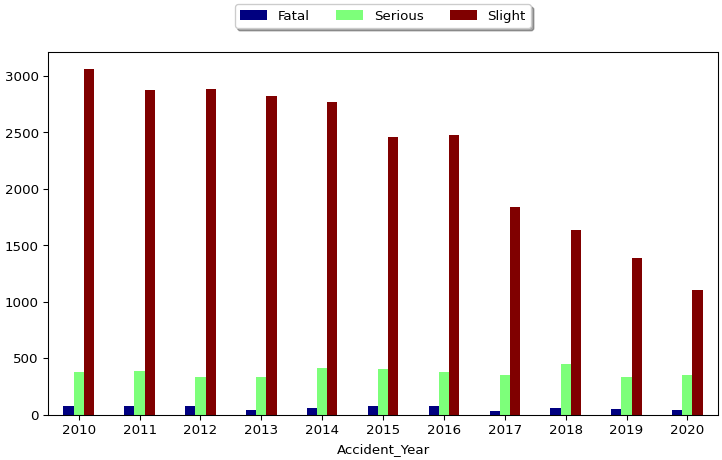

In [42]:
display(Leicestershire_cas3)

In [45]:
display(Leicestershire_acc3)


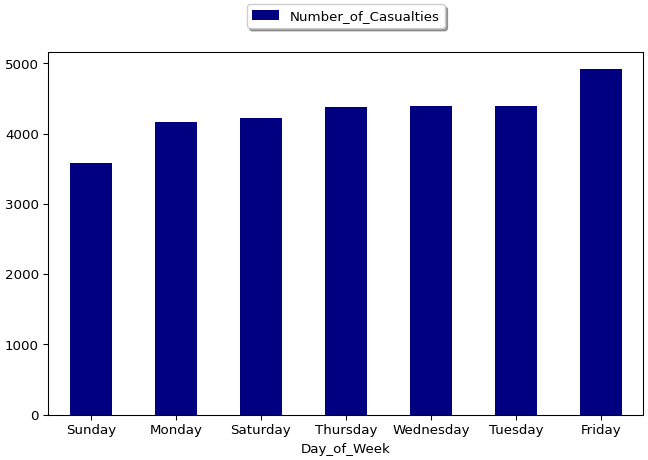

In [ ]:
display(Leicestershire_cas3)


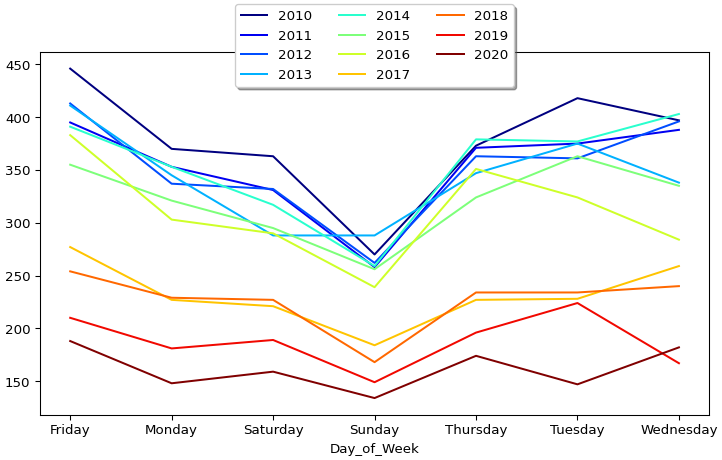

In [46]:
display(Leicestershire_acc3)

In [47]:
display(Leicestershire_acc3)

Accident_Index,Accident_Year,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_District,Road_Type,Speed_Limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions,Area_Type,Police_Officer_Attend_Accident,Month,quarter
2010331000057,2010,-1.12598,52.632749,Slight,1.0,1.0,2010-01-03,Sunday,05:56,Leicester,Dual Carriageway,30,Dark/lights lit,Other,Frost/Ice,None,Urban,Yes,January,1
2010331000239,2010,-0.588608,52.668023,Slight,1.0,2.0,2010-01-11,Monday,15:25,Rutland,Single Carriageway,30,Daylight,Other,Snow,None,Rural,Yes,January,1
2010331000512,2010,-1.135117,52.65646,Slight,2.0,3.0,2010-01-22,Friday,08:26,Leicester,Dual Carriageway,40,Daylight,Rain no high winds,Wet,None,Urban,Yes,January,1
2010331000586,2010,-1.291684,52.69274,Slight,2.0,1.0,2010-01-28,Thursday,16:28,Hinckley and Bosworth,Dual Carriageway,70,Darkn/no Lighting,Rain no high winds,Wet,None,Rural,Yes,January,1
2010331000816,2010,-1.062381,52.601066,Slight,1.0,2.0,2010-02-01,Monday,09:06,Oadby and Wigston,Single Carriageway,30,Daylight,Fine,Frost/Ice,None,Urban,Yes,February,1
2010331000824,2010,-1.180365,52.410537,Slight,1.0,1.0,2010-02-13,Saturday,02:40,Harborough,Dual Carriageway,70,Darkn/no Lighting,Fine,Wet,None,Rural,Yes,February,1
2010331000856,2010,-1.12588,52.645154,Slight,2.0,1.0,2010-02-12,Friday,14:56,Leicester,Roundabout,30,Daylight,Other,Wet,None,Urban,No,February,1
2010331000903,2010,-1.196661,52.605739,Slight,2.0,2.0,2010-02-14,Sunday,18:50,Blaby,Dual Carriageway,70,Dark/lights lit,Fine,Dry,None,Urban,Yes,February,1
2010331001328,2010,-1.158105,52.56025,Slight,1.0,1.0,2010-03-05,Friday,15:45,Blaby,Single Carriageway,40,Daylight,Fine,Dry,None,Rural,Yes,March,1
2010331001337,2010,-1.119612,52.581907,Slight,3.0,1.0,2010-03-08,Monday,19:10,Oadby and Wigston,Single Carriageway,30,Dark/lights lit,Fine,Dry,None,Urban,Yes,March,1


In [77]:
display(Leicestershire_acc3)